##### Step 3
Train a NN to fit the Predator-Prey cycle using GAN architecture.

<div>
<img src="prey.gif" width="500"/>
</div>

**Imports**

In [251]:
import numpy as np
import scipy
import random

import numba

import torch
from torch import nn
import torch.optim as optim

import seaborn as sns
import matplotlib.pylab as plt
import matplotlib.animation

from time import time
from IPython.display import display, clear_output


**Disabling autoscrolling for long output:**

In [39]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

**Device - GPU / CPU**

In [40]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DEVICE

device(type='cuda')

## DISTRIBUTION: Predetor - Prey 

The predator-prey model is summarized by these ordinary differential equations (ODE):

$$
\frac{dx}{dt} = b x - h x y \\
\frac{dy}{dt} = \epsilon h x y - d y
$$

where the parameters are:
- $x$ is the density of the *prey* (hare, gnu, mouse)
- $y$ is the density of the *predator* (lynx, lion, owl)
- $b$ is the *prey* birth rate
- $d$ is the *predator* death rate
- $h$ is the rate at which, when *predator* and *prey* meet, predation occurs
- $\epsilon$ is the rate at which *prey* density is converted to *predator* density when predation occurs

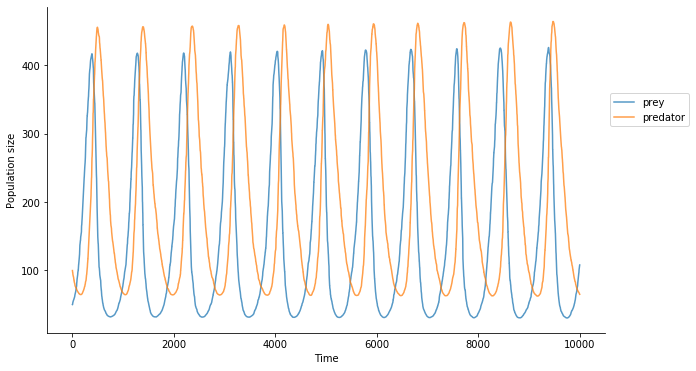

In [330]:
def dxydt(t, xy, b, h, ϵ, d):
    x, y = xy
    dx = b * x - h * x * y
    dy = ϵ * h * x * y - d * y
    return np.array([dx, dy])

# model parameters
b = 1
h = 0.005
ϵ = 0.8
d = 0.6

# number integration steps
steps = 100000 

# population array
xy = np.empty((2, steps)) 

# initial population sizes
xy[:,0] = 50, 100 

# time step for integration
dt = 0.001 

for t in range(1, steps):
    xy[:, t] = xy[:, t-1] + dxydt(t, xy[:, t-1], b, h, ϵ, d) * dt

prey = xy[0, :]
predator = xy[1, :]


# prey_dist = lambda num: torch.tensor(np.random.choice(prey,num)[:,None]).float()
# pred_dist = lambda num: torch.tensor(np.random.choice(predator,num)[:,None]).float()
prey_dist =  lambda num: torch.tensor(sorted(random.choices(list(enumerate(prey)),k=num), key=lambda tup: tup[0]))[:,1].float()[:,None]
pred_dist =  lambda num: torch.tensor(sorted(random.choices(list(enumerate(predator)),k=num), key=lambda tup: tup[0]))[:,1].float()[:,None]

t = np.arange(0, dt * steps, dt)


plt.figure(figsize=(10,6))

num = 10000
plt.plot(prey_dist(num), alpha=0.75, label='prey')
plt.plot(pred_dist(num), alpha=0.75, label='predator')

plt.xlabel('Time')
plt.ylabel('Population size')

# bbox_to_anchor places the legend at specific position, in this case outside the plot
plt.legend(bbox_to_anchor=(1, 0.75))
sns.despine()

In [161]:
pred_dist(10).shape

torch.Size([10, 1])

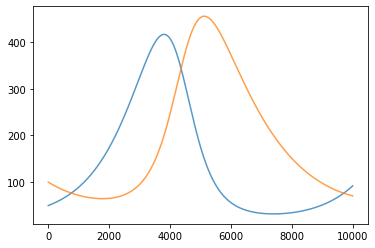

In [243]:
steps = 10000

# population array
xy = np.empty((2, steps)) 

# initial population sizes
xy[:,0] = 50, 100 

# time step for integration
dt = 0.001 

for t in range(1, steps):
    xy[:, t] = xy[:, t-1] + dxydt(t, xy[:, t-1], b, h, ϵ, d) * dt

plt.plot(xy[0,:], alpha=0.75, label='prey')
plt.plot(xy[1,:], alpha=0.75, label='predator')

In [246]:
t = torch.tensor(xy)
t.shape,t


(torch.Size([2, 10000]),
 tensor([[ 50.0000,  50.0250,  50.0500,  ...,  91.9288,  91.9883,  92.0478],
         [100.0000,  99.9600,  99.9200,  ...,  70.7065,  70.6901,  70.6737]],
        dtype=torch.float64))

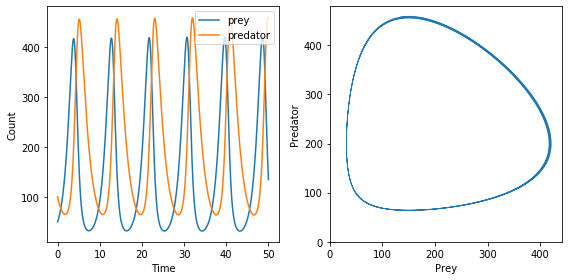

In [247]:
def dxydt(t, xy, b, h, ϵ, d):
    x, y = xy
    dx = b * x - h * x * y
    dy = ϵ * h * x * y - d * y
    return np.array([dx, dy])


b = 1
h = 0.005
ϵ = 0.8
d = 0.6

steps = 50000
XY = np.empty((2, steps))
XY[:,0] = 50, 100
dt = 0.001

for t_ in range(1, steps):
    XY[:,t_] = XY[:, t_-1] + dxydt(t_, XY[:, t_-1], b, h, ϵ, d) * dt
X, Y = XY
T = np.arange(0, steps*dt, dt)


fig, axes = plt.subplots(1, 2, figsize=(8, 4))

ax = axes[0]
ax.plot(T, X, label='prey')
ax.plot(T, Y, label='predator')
ax.set_xlabel('Time')
ax.set_ylabel('Count')
ax.legend();

ax = axes[1]
ax.plot(X, Y, lw=0.5)
ax.set_xlabel('Prey')
ax.set_ylabel('Predator')
ax.set(xlim=(0, None), ylim=(0, None))

fig.tight_layout()

In [479]:
@numba.jit
def get_rates(x, y, b, h, ϵ, d): ###
    return np.array([
      b*x,          # prey born
      (1-ϵ)*h*x*y,  # prey killed, no predator born
      ϵ*h*x*y,      # prey killed, predator born
      d*y,          # predator killed
    ])


@numba.jit # numba.jit not working due to the assert
def draw_time(rates): ###
#     assert rates.sum() > 0, rates
    return np.random.exponential( 1/rates.sum() )

@numba.jit
def draw_reaction(rates): ###
    rates /= rates.sum()
    return np.random.multinomial(1, rates).argmax()

updates = np.array([
  [ 1, 0],   # prey born
  [-1, 0],   # prey killed, no predator born
  [-1, 1],   # prey killed, predator born
  [ 0,-1],   # predator killed
])

@numba.jit
def gillespie_step(x, y, b, h, ϵ, d): ###
    rates = get_rates(x, y, b, h, ϵ, d)
    Δt = draw_time(rates)
    ri = draw_reaction(rates)
    Δx, Δy = updates[ri]
    return Δt, Δx, Δy


def gillespie_ssa(b, h, ϵ, d, times_,t0=0, x0=X[0], y0=Y[0], t_steps=steps, tmax=steps*dt,padding=False): ###
    xx = np.full(steps,0,dtype='int')
    yy = np.full(steps,0,dtype='int')

    t = 0
    i = 0
    xx[0] = x0
    yy[0] = y0

    while t<tmax and yy[i]!=0:
        
        if times_[i] <= t:
            i += 1
            xx[i] = xx[i-1]
            yy[i] = yy[i-1]
        else:
            # update
            Δt, Δx, Δy = gillespie_step(xx[i], yy[i], b, h, ϵ, d)

            t     = t+Δt
            xx[i] = xx[i]+Δx
            yy[i] = yy[i]+Δy

    if i <= steps and not padding:
        return np.array([times_[:i+1],xx[:i+1],yy[:i+1]])       
    else:
        return np.array([times_,xx,yy])

times = np.linspace(0, steps*dt, steps)
t,x,y = gillespie_ssa(b, h, ϵ, d,times_=times)
t,x,y

(array([0.00000000e+00, 1.00001000e-03, 2.00002000e-03, ...,
        7.67407674e+01, 7.67417674e+01, 7.67427674e+01]),
 array([50., 50., 50., ...,  0.,  0.,  0.]),
 array([100.,  99.,  99., ...,   1.,   1.,   0.]))

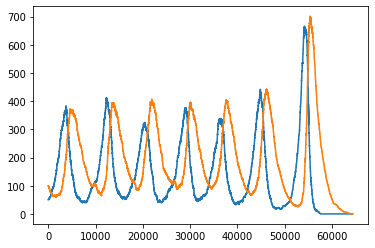

In [418]:
plt.plot(x)
plt.plot(y)

In [480]:
def sample_data(num=1000):
    indices = np.sort(np.random.choice(len(x),1000,replace=False))
    return np.array([x[indices],y[indices]])

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from tensorflow.keras import Input
from tensorflow.keras.layers import *# Dense,Activation,Conv1D,Reshape,Dropout,Flatten
from tensorflow.keras.optimizers import SGD,Adam
from tensorflow.keras.models import Model

import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm_notebook as tqdm
from keras.models import Model
from keras.layers import Input, Reshape
from keras.layers.core import Dense, Activation, Dropout, Flatten
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import UpSampling1D, Conv1D
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import Adam, SGD
from keras.callbacks import TensorBoard


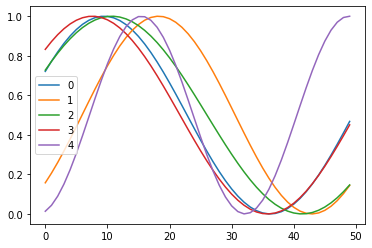

In [2]:

def sample_data(n_samples=10000, x_vals=np.arange(0, 5, .1), max_offset=100, mul_range=[1, 2]):
    vectors = []
    for i in range(n_samples):
        offset = np.random.random() * max_offset
        mul = mul_range[0] + np.random.random() * (mul_range[1] - mul_range[0])
        vectors.append(
            np.sin(offset + x_vals * mul) / 2 + .5
        )
    return np.array(vectors)

ax = pd.DataFrame(np.transpose(sample_data(5))).plot()

In [3]:
def get_generative(G_in, dense_dim=200, out_dim=50, lr=1e-3):
    x = Dense(dense_dim)(G_in)
    x = Activation('tanh')(x)
    G_out = Dense(out_dim, activation='tanh')(x)
    G = Model(G_in, G_out)
    opt = SGD(lr=lr)
    G.compile(loss='binary_crossentropy', optimizer=opt)
    return G, G_out

G_in = Input(shape=[10])
G, G_out = get_generative(G_in)
G.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 10)]              0         
_________________________________________________________________
dense (Dense)                (None, 200)               2200      
_________________________________________________________________
activation (Activation)      (None, 200)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                10050     
Total params: 12,250
Trainable params: 12,250
Non-trainable params: 0
_________________________________________________________________


In [4]:
def get_discriminative(D_in, lr=1e-3, drate=.25, n_channels=50, conv_sz=5, leak=.2):
    x = Reshape((-1, 1))(D_in)
    x = Conv1D(n_channels, conv_sz, activation='relu')(x)
    x = Dropout(drate)(x)
    x = Flatten()(x)
    x = Dense(n_channels)(x)
    D_out = Dense(2, activation='sigmoid')(x)
    D = Model(D_in, D_out)
    dopt = Adam(lr=lr)
    D.compile(loss='binary_crossentropy', optimizer=dopt)
    return D, D_out

D_in = Input(shape=[50])
D, D_out = get_discriminative(D_in)
D.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 50)]              0         
_________________________________________________________________
reshape (Reshape)            (None, 50, 1)             0         
_________________________________________________________________
conv1d (Conv1D)              (None, 46, 50)            300       
_________________________________________________________________
dropout (Dropout)            (None, 46, 50)            0         
_________________________________________________________________
flatten (Flatten)            (None, 2300)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 50)                115050    
_________________________________________________________________
dense_3 (Dense)              (None, 2)                

In [5]:
def set_trainability(model, trainable=False):
    model.trainable = trainable
    for layer in model.layers:
        layer.trainable = trainable
        
def make_gan(GAN_in, G, D):
    set_trainability(D, False)
    x = G(GAN_in)
    GAN_out = D(x)
    GAN = Model(GAN_in, GAN_out)
    GAN.compile(loss='binary_crossentropy', optimizer=G.optimizer)
    return GAN, GAN_out

GAN_in = Input([10])
GAN, GAN_out = make_gan(GAN_in, G, D)
GAN.summary()

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 10)]              0         
_________________________________________________________________
functional_1 (Functional)    (None, 50)                12250     
_________________________________________________________________
functional_3 (Functional)    (None, 2)                 115452    
Total params: 127,702
Trainable params: 12,250
Non-trainable params: 115,452
_________________________________________________________________


In [7]:
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

def sample_data_and_gen(G, noise_dim=10, n_samples=10000):
    XT = sample_data(n_samples=n_samples)
    XN_noise = np.random.uniform(0, 1, size=[n_samples, noise_dim])
    XN = G.predict(XN_noise)
    X = np.concatenate((XT, XN))
    y = np.zeros((2*n_samples, 2))
    y[:n_samples, 1] = 1
    y[n_samples:, 0] = 1
    return X, y

def pretrain(G, D, noise_dim=10, n_samples=10000, batch_size=32):
    X, y = sample_data_and_gen(G, n_samples=n_samples, noise_dim=noise_dim)
    set_trainability(D, True)
    D.fit(X, y, epochs=1, batch_size=batch_size)

pretrain(G, D)

InternalError: GPU sync failed

In [519]:
def sample_noise(G, noise_dim=10, n_samples=10000):
    X = np.random.uniform(0, 1, size=[n_samples, noise_dim])
    y = np.zeros((n_samples, 2))
    y[:, 1] = 1
    return X, y

def train(GAN, G, D, epochs=500, n_samples=10000, noise_dim=10, batch_size=32, verbose=False, v_freq=50):
    d_loss = []
    g_loss = []
    e_range = range(epochs)
    if verbose:
        e_range = tqdm(e_range)
    for epoch in e_range:
        X, y = sample_data_and_gen(G, n_samples=n_samples, noise_dim=noise_dim)
        set_trainability(D, True)
        d_loss.append(D.train_on_batch(X, y))
        
        X, y = sample_noise(G, n_samples=n_samples, noise_dim=noise_dim)
        set_trainability(D, False)
        g_loss.append(GAN.train_on_batch(X, y))
        if verbose and (epoch + 1) % v_freq == 0:
            print("Epoch #{}: Generative Loss: {}, Discriminative Loss: {}".format(epoch + 1, g_loss[-1], d_loss[-1]))
    return d_loss, g_loss

d_loss, g_loss = train(GAN, G, D, verbose=True)

C:\Users\sahar\anaconda3\lib\site-packages\ipykernel_launcher.py:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if sys.path[0] == '':


UnknownError:  Failed to get convolution algorithm. This is probably because cuDNN failed to initialize, so try looking to see if a warning log message was printed above.
	 [[node functional_17/conv1d_5/conv1d (defined at <ipython-input-519-91a125141858>:16) ]] [Op:__inference_train_function_7845]

Function call stack:
train_function


In [510]:
ax = pd.DataFrame(
    {
        'Generative Loss': g_loss,
        'Discriminative Loss': d_loss,
    }
).plot(title='Training loss', logy=True)
ax.set_xlabel("Epochs")
ax.set_ylabel("Loss")

NameError: name 'g_loss' is not defined

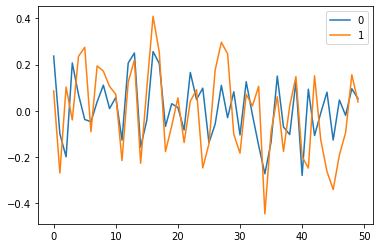

In [511]:
N_VIEWED_SAMPLES = 2
data_and_gen, _ = sample_data_and_gen(G, n_samples=N_VIEWED_SAMPLES)
pd.DataFrame(np.transpose(data_and_gen[N_VIEWED_SAMPLES:])).plot()

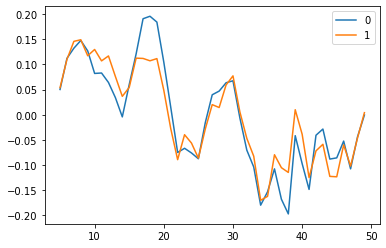

In [512]:
N_VIEWED_SAMPLES = 2
data_and_gen, _ = sample_data_and_gen(G, n_samples=N_VIEWED_SAMPLES)
pd.DataFrame(np.transpose(data_and_gen[N_VIEWED_SAMPLES:])).rolling(5).mean()[5:].plot()

In [485]:
# GENERATOR

gen = keras.Sequential()
gen.add(keras.Input((2,128)))
gen.add(layers.Dense(64,activation='relu'))
gen.add(layers.Dense(32,activation='relu'))
gen.add(layers.Dense(32,activation='relu'))
gen.add(layers.Dense(16,activation='relu'))
gen.add(layers.Dense(8,activation='relu'))
gen.add(layers.Dense(4,activation='relu'))
gen.add(layers.Dense(2))
gen.summary()

Model: "sequential_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_105 (Dense)            (None, 2, 500)            500500    
_________________________________________________________________
dense_106 (Dense)            (None, 2, 100)            50100     
_________________________________________________________________
dense_107 (Dense)            (None, 2, 32)             3232      
_________________________________________________________________
dense_108 (Dense)            (None, 2, 16)             528       
_________________________________________________________________
dense_109 (Dense)            (None, 2, 8)              136       
_________________________________________________________________
dense_110 (Dense)            (None, 2, 4)              36        
_________________________________________________________________
dense_111 (Dense)            (None, 2, 2)            

In [338]:
# DISCRIMINATOR

dis = keras.Sequential()
dis.add(keras.Input( (4)  ))  
dis.add(layers.Dense(32,activation='relu'))
dis.add(layers.Dense(16,activation='relu'))
dis.add(layers.Dense(8,activation='relu'))
dis.add(layers.Dense(4,activation='relu'))
dis.add(layers.Dense(2,activation='softmax'))
dis.summary()

Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_78 (Dense)             (None, 32)                160       
_________________________________________________________________
dense_79 (Dense)             (None, 16)                528       
_________________________________________________________________
dense_80 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_81 (Dense)             (None, 4)                 36        
_________________________________________________________________
dense_82 (Dense)             (None, 2)                 10        
Total params: 870
Trainable params: 870
Non-trainable params: 0
_________________________________________________________________


In [339]:
# optimizer & loss function & metric
opt = keras.optimizers.Adam()
loss_fn = keras.losses.BinaryCrossentropy()

# model compile
gen.compile(loss='binary_crossentropy',optimizer=keras.optimizers.Adam(),metrics=['accuracy'])
dis.compile(loss='binary_crossentropy',optimizer=keras.optimizers.Adam(),metrics=['accuracy'])

# model fit
# train_time = time()
# history = model.fit(x=x_train,y=y_train,epochs=10,batch_size=100,validation_split=0.1)
# train_time = time() - train_time

# score trained model
# loss, acc = model.evaluate(x_test, y_test, verbose=1)

# return (history.history,loss,acc,train_time)

In [342]:
dis.trainable=False
gan_input = keras.Input(shape=(2,))
x = gen(gan_input)
print(x.shape)
gan_output= dis(x)
gan= Model(inputs=gan_input, outputs=gan_output)
gan.compile(loss='binary_crossentropy', optimizer='adam')
return gan
gan = create_gan(d,g)
gan.summary()

(None, 2)


ValueError: Input 0 of layer sequential_26 is incompatible with the layer: expected axis -1 of input shape to have value 4 but received input with shape [None, 2]

In [324]:
vec = np.random.rand(2)[None,:]
print(vec)
gen.predict(vec)

[[0.37568899 0.84179249]]


array([[ 0.00030244, -0.02033259]], dtype=float32)

In [ ]:
keras.models.Model()

## GENERATOR

In [43]:
class Generator_distribution(nn.Module):
    def __init__(self,input_dim=1):
        # initialize nn Module
        super().__init__()
        
        self.layers = nn.ModuleList() 
        
        # architecture
        self.layers.append(nn.Linear(input_dim,64))
        self.layers.append(nn.LeakyReLU())
        self.layers.append(nn.Linear(64,32))
        self.layers.append(nn.LeakyReLU())
        self.layers.append(nn.Linear(32,1))
        
    def forward(self,input_tensor):
        x = input_tensor.to(DEVICE)
        for l in self.layers:
            x = l(x)
        return x
    
yoyo = Generator_distribution().to(DEVICE)
yoyo.forward(torch.rand(10,1))

tensor([[0.1484],
        [0.1644],
        [0.1462],
        [0.1488],
        [0.1618],
        [0.1518],
        [0.1655],
        [0.1466],
        [0.1469],
        [0.1495]], device='cuda:0', grad_fn=<AddmmBackward>)

## DISCRIMINATOR

In [151]:
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)
    
class Discriminator_distribution(nn.Module):
    def __init__(self,input_dim=1):
        super().__init__()
        
        self.layers = nn.ModuleList() 
        
        self.layers.append(nn.Linear(64,32))
        self.layers.append(nn.LeakyReLU())
        self.layers.append(nn.Linear(32,16))
        self.layers.append(nn.LeakyReLU())
        self.layers.append(nn.Linear(16,8))
        self.layers.append(nn.LeakyReLU())
        self.layers.append(nn.Linear(8,1))
        self.layers.append(nn.Sigmoid())
    
    def forward(self,input_tensor):
        x = input_tensor.to(DEVICE)
        for l in self.layers:
            print(x.shape)
            x = l(x)
        return x

vec = pred_dist(64)[None,:]
print(vec.shape,vec)
yoyo = Discriminator_distribution(input_dim=1).to(DEVICE)
t = yoyo.forward(vec)
t.shape,t[0]




torch.Size([1, 64, 1]) tensor([[[ 86.1036],
         [ 68.3462],
         [ 64.6936],
         [139.3778],
         [301.1009],
         [246.3158],
         [ 88.2846],
         [ 65.9085],
         [ 64.4467],
         [ 73.4438],
         [ 98.1588],
         [281.1021],
         [405.3278],
         [320.1487],
         [128.9573],
         [162.2417],
         [ 67.4238],
         [ 69.2293],
         [264.3453],
         [396.5270],
         [418.9182],
         [387.0288],
         [311.7391],
         [272.0709],
         [188.5104],
         [117.8569],
         [ 91.0411],
         [250.9214],
         [214.9037],
         [105.4311],
         [ 68.8001],
         [442.2644],
         [201.4741],
         [ 78.0514],
         [132.1842],
         [363.6653],
         [344.6084],
         [192.3357],
         [186.3951],
         [127.4214],
         [104.4921],
         [ 93.3375],
         [ 65.4442],
         [ 67.9631],
         [ 83.4001],
         [ 86.6581],
         [2

(torch.Size([1, 1]),
 tensor([0.4847], device='cuda:0', grad_fn=<SelectBackward>))

## Gan

In [127]:
class GAN_distribution():
    def __init__(self,batch_size=64,n_epochs=2,lr_generator=0.0002,lr_discriminator=0.0004,from_dist=torch.rand,to_dist=prey_dist):
        
        # models
        self.generator     = Generator_distribution().to(DEVICE)
        self.discriminator = Discriminator_distribution().to(DEVICE)
        
        # criterion
        self.criterion = nn.BCELoss().to(DEVICE)
        
        # optimizers
        self.optim_generator     = optim.Adam(self.generator.parameters(),    lr=lr_generator)
        self.optim_discriminator = optim.Adam(self.discriminator.parameters(),lr=lr_discriminator)
        
        # distrebutions from & to
        self.initial = from_dist
        self.real    = to_dist
        
        # batch
        self.batch_size = batch_size
            
        # epochs    
        self.n_epochs=n_epochs

        # helper for loss
        self.ones = (torch.ones((batch_size, 1))*0.95).to(DEVICE)
        self.zeros = torch.zeros((batch_size, 1)).to(DEVICE)
        
        
    def sample_gen(self,num=1000):
        with torch.no_grad():
                return self.generator(self.initial((num,1))).to(DEVICE)
     
    
    def train_step(self):
        loss_discriminator = self.train_step_discriminator()
        loss_generator = self.train_step_generator()
        return loss_generator,loss_discriminator
   
    
    def train_step_generator(self):
        
        self.generator.zero_grad()
        
        # gen
        sample = self.initial((self.batch_size,1)).to(DEVICE)
        gen = self.generator(sample).to(DEVICE)
        cls = self.discriminator(gen).to(DEVICE)
        
        # adjusting the gen's Ws in order to fool the discriminator
        loss = self.criterion(cls,self.ones)
        loss.backward()
        self.optim_generator.step()
        return loss.item()
    
    
    def train_step_discriminator(self):
        
        self.discriminator.zero_grad()
        
        # real
        sample = self.real(self.batch_size).to(DEVICE)
        pred_real = self.discriminator(sample[None,:]).to(DEVICE)
        print(pred_real.shape)
        loss_real = self.criterion(pred_real,self.ones)
        
        # gen
        sample = self.initial((self.batch_size,1)).to(DEVICE)
        with torch.no_grad():
            gen = self.generator(sample).to(DEVICE)
        pred_fake = self.discriminator(gen).to(DEVICE)
        loss_fake = self.criterion(pred_fake,self.zeros)
        
        # combine losses
        loss = (loss_real + loss_fake)/2
        loss.backward()
        self.optim_discriminator.step()
        return loss_real.item(),loss_fake.item()

    
    def train(self,verbose_instead_of_animation=False):
        self.loss_g, self.loss_d_real, self.loss_d_fake = [], [], []

        self.samples = []
        start = time()
        for epoch in range(self.n_epochs):
            
            loss_g_running, loss_d_real_running, loss_d_fake_running = 0, 0, 0
            
            for batch in range(self.batch_size):
                lg_, (ldr_, ldf_) = self.train_step()
                loss_g_running += lg_
                loss_d_real_running += ldr_
                loss_d_fake_running += ldf_
            
            self.loss_g.append(loss_g_running / self.batch_size)
            self.loss_d_real.append(loss_d_real_running / self.batch_size)
            self.loss_d_fake.append(loss_d_fake_running / self.batch_size)
            self.samples.append(self.sample_gen().to('cpu'))
            
            if verbose_instead_of_animation :#and ((epoch+1)%10==0):
                print(f"Epoch {epoch+1}/{self.n_epochs} ({int(time() - start)}s):"
                      f" G={self.loss_g[-1]:.3f},"
                      f" Dr={self.loss_d_real[-1]:.3f},"
                      f" Df={self.loss_d_fake[-1]:.3f}")
        
        if not verbose_instead_of_animation:
            self.plot_animation()
        
    
    def plot(self,num=100):
        fig, ax = plt.subplots(1,2,figsize=(18,6))

        # plot Loss
        ax[0].plot(self.loss_g,label='Generator Loss')
        ax[0].plot(self.loss_d_real,label='Discriminator Loss on Real data')
        ax[0].plot(self.loss_d_fake,label='Discriminator Loss on Fake data')
        ax[0].set_title('Loss')
        ax[0].legend()

        # plot distribution
        arr = self.sample_gen(num=num).detach().numpy()
        sns.distplot(self.real(num),label='Real',hist_kws=dict(alpha=1),ax=ax[1])
        sns.distplot(arr,label='GAN',hist_kws=dict(alpha=0.5),ax=ax[1])
        ax[1].set_title('Distributions')
        ax[1].legend()
        
    def plot_animation(self):
        fig, ax = plt.subplots(1,2,figsize=(18,6))
        
        # Plot Loss
        l, = ax[0].plot([0,10],[0,2])
        l2, = ax[0].plot([0,10],[0,2])
        l3, = ax[0].plot([0,10],[0,2])
        ax[0].legend(['Generator Loss','Discriminator Loss on Real data','Discriminator Loss on Fake data'])
        ax[0].set_title('Loss')

        # Plot loss - animations functions
        animate_g = lambda i: l.set_data(t[:i], self.loss_g[:i])
        animate_d_real = lambda i: l2.set_data(t[:i], self.loss_d_real[:i])
        animate_d_fake = lambda i: l3.set_data(t[:i], self.loss_d_fake[:i])
        
        # Plot distribution
        num = len(self.samples[0])
        real_ = self.real(num)
        fake_ = [np.array(s) for s in self.samples]
        
        # Plot distribution - animation function
        def animate_samples(i):
            ax[1].clear();
            ax[1].plot(real_,label='Real',alpha=1)
            ax[1].plot(fake_[i],label='GAN',alpha=0.5)
#             sns.distplot(real_,label='Real',hist_kws=dict(alpha=1),ax=ax[1])
#             sns.distplot(fake_[i],label='GAN',hist_kws=dict(alpha=0.5),ax=ax[1])
            ax[1].legend()
            ax[1].set_title('Distributions')

            
        # Plot each epoch - Loss & distribution
        for i in range(self.n_epochs):
            # call animation functions
            animate_g(i)
            animate_d_real(i)
            animate_d_fake(i)
            animate_samples(i)
            
            # clear output anf dislay figure
            clear_output(wait=True)
            display(fig)
            
            # Plot Loss - scale the plot by new values
            ax[0].relim()
            ax[0].autoscale_view(True,True)
            
            # Plot distribution - scale the plot by new values
            ax[1].relim()
            ax[1].autoscale_view(True,True)
            
            # show entire plot
            plt.show()
            
gan = GAN_distribution(n_epochs=10)
gan.train(verbose_instead_of_animation=True)

torch.Size([1, 1])


ValueError: Target and input must have the same number of elements. target nelement (64) != input nelement (1)

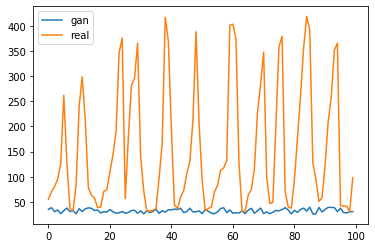

In [53]:
num = 100

plt.plot(gan.sample_gen(num).cpu().numpy(),label='gan')
plt.plot(prey_dist(num),label='real')
plt.legend()

In [ ]:
gan.sample_gen(100).cpu().numpy()[:10]